In [1]:
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
import math

def autopad(k, p=None, d=1):   
   
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]   
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]   
    return p

class Conv(nn.Module):
   
    default_act = nn.SiLU()   

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
         
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        
        return self.act(self.conv(x))

class GhostConv(nn.Module):
   

    def __init__(self, c1, c2, k=3, s=1, g=1, act=True):
       
        super().__init__()
        c_ = c2//2  
        self.cv1 = Conv(c1, c_, k, s, None, g, act=act)
        self.cv2 = Conv(c_, c_, 5, 1, None, c_, act=act)

    def forward(self, x):
      
        y = self.cv1(x)
        return torch.cat((y, self.cv2(y)), 1)

if __name__ == '__main__':
    net = GhostConv(c1=3,c2=32)
    
    net.cuda()
    summary(net, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             432
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              SiLU-3         [-1, 16, 256, 256]               0
              SiLU-4         [-1, 16, 256, 256]               0
              Conv-5         [-1, 16, 256, 256]               0
            Conv2d-6         [-1, 16, 256, 256]             400
       BatchNorm2d-7         [-1, 16, 256, 256]              32
              SiLU-8         [-1, 16, 256, 256]               0
              SiLU-9         [-1, 16, 256, 256]               0
             Conv-10         [-1, 16, 256, 256]               0
Total params: 896
Trainable params: 896
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 80.00
Params size (MB): 0.00
Estimated Total Si

In [3]:
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torchsummary import summary
class Auxiliary(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(Auxiliary, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):

        feat1 = self.features[  :4 ](x)
        feat2 = self.features[4 :9 ](feat1)
        feat3 = self.features[9 :13](feat2)
        feat4 = self.features[13:15](feat3)


        return [feat1, feat2, feat3, feat4]

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False, in_channels = 3):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = GhostConv(in_channels, v,)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfgs = {
    'D': [32, 'M',64, 128,'M', 256, 'M', 512, 'M',1024,]
}


def Auxiliary_net(pretrained, in_channels = 3, **kwargs):
    model = Auxiliary(make_layers(cfgs["D"], batch_norm = False, in_channels = in_channels), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/vgg16-397923af.pth", model_dir="./model_data")
        model.load_state_dict(state_dict)
    
    del model.avgpool
    del model.classifier
    return model

if __name__ == '__main__':
    net = Auxiliary_net(pretrained=False,in_channels=3)

    
    net.cuda()
    summary(net, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             432
       BatchNorm2d-2         [-1, 16, 512, 512]              32
              SiLU-3         [-1, 16, 512, 512]               0
              SiLU-4         [-1, 16, 512, 512]               0
              SiLU-5         [-1, 16, 512, 512]               0
              SiLU-6         [-1, 16, 512, 512]               0
              SiLU-7         [-1, 16, 512, 512]               0
              SiLU-8         [-1, 16, 512, 512]               0
              SiLU-9         [-1, 16, 512, 512]               0
             SiLU-10         [-1, 16, 512, 512]               0
             SiLU-11         [-1, 16, 512, 512]               0
             SiLU-12         [-1, 16, 512, 512]               0
             SiLU-13         [-1, 16, 512, 512]               0
             SiLU-14         [-1, 16, 5

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
import math

def autopad(k, p=None, d=1):   
     
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  
    return p

class Conv(nn.Module):
    
    default_act = nn.SiLU()  

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
         
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
       
        return self.act(self.conv(x))

class GhostConv(nn.Module):
    

    def __init__(self, c1, c2, k=3, s=1, g=1, act=True):
         
        super().__init__()
        c_ = c2//2  
        self.cv1 = Conv(c1, c_, k, s, None, g, act=act)
        self.cv2 = Conv(c_, c_, 5, 1, None, c_, act=act)

    def forward(self, x):
        
        y = self.cv1(x)
        return torch.cat((y, self.cv2(y)), 1)

if __name__ == '__main__':
    net = GhostConv(c1=3,c2=32)
    
    net.cuda()
    summary(net, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             432
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              SiLU-3         [-1, 16, 256, 256]               0
              SiLU-4         [-1, 16, 256, 256]               0
              Conv-5         [-1, 16, 256, 256]               0
            Conv2d-6         [-1, 16, 256, 256]             400
       BatchNorm2d-7         [-1, 16, 256, 256]              32
              SiLU-8         [-1, 16, 256, 256]               0
              SiLU-9         [-1, 16, 256, 256]               0
             Conv-10         [-1, 16, 256, 256]               0
Total params: 896
Trainable params: 896
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 80.00
Params size (MB): 0.00
Estimated Total Si

In [5]:
import math

import torch.nn as nn
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups

        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)

        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)

        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):

        self.inplanes = 64
        super(ResNet, self).__init__()
        # 600,600,3 -> 300,300,64
        self.conv1  = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1    = nn.BatchNorm2d(64)
        self.relu   = nn.ReLU(inplace=True)
        # 300,300,64 -> 150,150,64
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True) # change
        # 150,150,64 -> 150,150,256
        self.layer1 = self._make_layer(block, 64, layers[0])
        # 150,150,256 -> 75,75,512
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # 75,75,512 -> 38,38,1024
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # 38,38,1024 -> 19,19,2048
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                    kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes * block.expansion),
        )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):


        x       = self.conv1(x)
        x       = self.bn1(x)
        feat1   = self.relu(x)

        x       = self.maxpool(feat1)
        feat2   = self.layer1(x)

        feat3   = self.layer2(feat2)
        feat4   = self.layer3(feat3)
        feat5   = self.layer4(feat4)
        return [feat1, feat2, feat3, feat4, feat5]

def resnet50(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url('https://s3.amazonaws.com/pytorch/models/resnet50-19c8e357.pth', model_dir='model_data'), strict=False)
    
    del model.avgpool
    del model.fc
    return model

def resnet150(pretrained=False, **kwargs):
     
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(
            model_zoo.load_url('https://s3.amazonaws.com/pytorch/models/resnet152-19c8e357.pth', model_dir='model_data'),
            strict=False)

    del model.avgpool
    del model.fc
    return model

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary


class SpatialAttention(nn.Module):
    def __init__(self, in_channl):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)

        self.conv1 = nn.Conv2d(in_channl, in_channl * 2, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(in_channl * 2)
        self.bn2 = nn.BatchNorm2d(in_channl * 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn(x0)
        avg_pool = torch.mean(x0, dim=1, keepdim=True)
        max_pool, _ = torch.max(x0, dim=1, keepdim=True)
        y = torch.cat([avg_pool, max_pool], dim=1)
        y = self.conv(y)
        y = self.sigmoid(y)
        y = x0 * y.expand_as(x0)
        return y


from torch import nn


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class UISS_NetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(UISS_NetUp, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs1, inputs2):
        outputs = torch.cat([inputs1, self.up(inputs2)], 1)
        outputs = self.conv1(outputs)
        outputs = self.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.relu(outputs)
        return outputs


class UISS_Net(nn.Module):
    def __init__(self, num_classes=21, pretrained=False, backbone='resnet50'):
        super(UISS_Net, self).__init__()
        if backbone == "resnet50":
            self.resnet = resnet50(pretrained=pretrained)
            self.vgg = Auxiliary_net(pretrained=False)
            in_filters = [192, 512, 1024, 3072]
        else:
            raise ValueError('Unsupported backbone - `{}`, Use  resnet50.'.format(backbone))
        out_filters = [64, 128, 256, 512]

        # upsampling
        # 64,64,512
        self.up_concat4 = UISS_NetUp(in_filters[3], out_filters[3])
        # 128,128,256
        self.up_concat3 = UISS_NetUp(in_filters[2], out_filters[2])
        # 256,256,128
        self.up_concat2 = UISS_NetUp(in_filters[1], out_filters[1])
        # 512,512,64
        self.up_concat1 = UISS_NetUp(in_filters[0], out_filters[0])

        if backbone == 'resnet50':
            self.up_conv = nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor=2),
                nn.Conv2d(out_filters[0], out_filters[0], kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_filters[0], out_filters[0], kernel_size=3, padding=1),
                nn.ReLU(),
            )
        else:
            self.up_conv = None

        self.final = nn.Conv2d(out_filters[0], num_classes, 1)
        self.c1 = nn.Conv2d(2048, 1024, 3, 1, 1)
        self.b1 = nn.BatchNorm2d(1024)
        self.c2 = nn.Conv2d(1024, 512, 3, 1, 1)
        self.b2 = nn.BatchNorm2d(512)
        self.c3 = nn.Conv2d(512, 256, 3, 1, 1)
        self.b3 = nn.BatchNorm2d(256)
        self.c4 = nn.Conv2d(128, 64, 3, 1, 1)
        self.b4 = nn.BatchNorm2d(64)
        self.conv = nn.Conv2d(512, 1024, 1)
        self.conv1 = nn.Conv2d(128, 64, 1)
        self.backbone = backbone
        self.a = 0.5
        self.con_down = nn.Conv2d(64, 256, 3, 2, 1)
        self.con_down11 = nn.Conv2d(512, 512, 1, 1, )
        self.con_down22 = nn.Conv2d(1024, 1024, 1, 1, )
        self.con_down33 = nn.Conv2d(2048, 2048, 1, 1, )
        self.con_down2 = nn.Conv2d(512, 256, 1, 1)

        self.con_down3 = nn.Conv2d(1024, 512, 1, 1)

        self.con_down4 = nn.Conv2d(2048, 1024, 1, 1)

        self.con_down5 = nn.Conv2d(4096, 2048, 1, 1)
        self.con_N1 = nn.Sequential(nn.Conv2d(64, 64, 1, 1), nn.ReLU(inplace=True))
        self.con_N2 = nn.Sequential(nn.Conv2d(128, 128, 1, 1), nn.ReLU(inplace=True))
        self.con_N3 = nn.Sequential(nn.Conv2d(256, 256, 1, 1), nn.ReLU(inplace=True))
        self.con_N4 = nn.Sequential(nn.Conv2d(512, 512, 1, 1), nn.ReLU(inplace=True))
        self.con_NC1 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1), nn.ReLU(inplace=True))
        self.con_NC2 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(inplace=True))
        self.con_NC3 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(inplace=True))
        self.con_NC4 = nn.Sequential(nn.Conv2d(1024, 1024, 3, 1, 1), nn.ReLU(inplace=True))
        self.se1 = SELayer(64)
        self.se2 = SELayer(256)
        self.se3 = SELayer(512)
        self.se4 = SELayer(1024)
        self.se5 = SELayer(2048)
        self.D1 = SpatialAttention(256)
        self.D2 = SpatialAttention(512)
        self.D3 = SpatialAttention(1024)
        self.relu = nn.ReLU(inplace=True)
        self.c_d1 = nn.Sequential(nn.Conv2d(1024, 512, 1, 1), nn.ReLU(inplace=True))
        self.c_d2 = nn.Sequential(nn.Conv2d(512, 256, 1, 1), nn.ReLU(inplace=True))
        self.c_d3 = nn.Sequential(nn.Conv2d(128, 64, 1, 1), nn.ReLU(inplace=True))
        self.cc_d3 = nn.Sequential(nn.Conv2d(128, 64, 1, 1), nn.ReLU(inplace=True))

    def forward(self, inputs):
        if self.backbone == "resnet50":
            [feat1, feat2, feat3, feat4, feat5] = self.resnet.forward(inputs)
            [feat11, feat22, feat33, feat44] = self.vgg.forward(inputs)
        feat1 = self.se1(feat1)
        feat2 = self.se2(feat2)
        feat3 = self.se3(feat3)
        feat4 = self.se4(feat4)
        feat5 = self.se5(feat5)


        feat4 = torch.cat([feat4, feat44], 1)
        feat4 = self.b1(self.c1(feat4))

        feat3 = torch.cat([feat3, feat33], 1)
        feat3 = self.b2(self.c2(feat3))
        feat2 = torch.cat([feat2, feat22], 1)
        feat2 = self.b3(self.c3(feat2))
        feat1 = torch.cat([feat1, feat11], 1)
        feat1 = self.b4(self.c4(feat1))

        up4 = self.up_concat4(feat4, feat5)

        x1 = nn.functional.interpolate(up4, size=feat3.size()[2:], mode='bilinear', align_corners=False)
        feat3 = torch.cat([x1, feat3], 1)
        feat3 = self.c_d1(feat3)

        up3 = self.up_concat3(feat3, up4)

        x2 = nn.functional.interpolate(up3, size=feat2.size()[2:], mode='bilinear', align_corners=False)
        feat2 = torch.cat([x2, feat2], 1)
        feat2 = self.c_d2(feat2)

        up2 = self.up_concat2(feat2, up3)

        x3 = nn.functional.interpolate(up2, size=feat1.size()[2:], mode='bilinear', align_corners=False)

        x3 = self.cc_d3(x3)

        feat1 = torch.cat([x3, feat1], 1)

        feat1 = self.c_d3(feat1)

        up1 = self.up_concat1(feat1, up2)
        if self.up_conv != None:
            up1 = self.up_conv(up1)

        final = self.final(up1)

        return final

    def freeze_backbone(self):
        if self.backbone == "vgg":
            for param in self.vgg.parameters():
                param.requires_grad = False
        elif self.backbone == "resnet50":
            for param in self.resnet.parameters():
                param.requires_grad = False

    def unfreeze_backbone(self):
        if self.backbone == "vgg":
            for param in self.vgg.parameters():
                param.requires_grad = True
        elif self.backbone == "resnet50":
            for param in self.resnet.parameters():
                param.requires_grad = True


if __name__ == '__main__':
    net = UISS_Net(pretrained=False)
 
    net.cuda()
    summary(net, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [7]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F


def CE_Loss(inputs, target, cls_weights, num_classes=21):
    n, c, h, w = inputs.size()
    nt, ht, wt = target.size()
    if h != ht and w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)

    temp_inputs = inputs.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    temp_target = target.view(-1)

    CE_loss  = nn.CrossEntropyLoss(weight=cls_weights, ignore_index=num_classes)(temp_inputs, temp_target)
    return CE_loss

def Focal_Loss(inputs, target, cls_weights, num_classes=21, alpha=0.5, gamma=2):
    n, c, h, w = inputs.size()
    nt, ht, wt = target.size()
    if h != ht and w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)

    temp_inputs = inputs.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    temp_target = target.view(-1)

    logpt  = -nn.CrossEntropyLoss(weight=cls_weights, ignore_index=num_classes, reduction='none')(temp_inputs, temp_target)
    pt = torch.exp(logpt)
    if alpha is not None:
        logpt *= alpha
    loss = -((1 - pt) ** gamma) * logpt
    loss = loss.mean()
    return loss

def Dice_loss(inputs, target, beta=1, smooth = 1e-5):
    n, c, h, w = inputs.size()
    nt, ht, wt, ct = target.size()
    if h != ht and w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)
        
    temp_inputs = torch.softmax(inputs.transpose(1, 2).transpose(2, 3).contiguous().view(n, -1, c),-1)
    temp_target = target.view(n, -1, ct)


    tp = torch.sum(temp_target[...,:-1] * temp_inputs, axis=[0,1])
    fp = torch.sum(temp_inputs                       , axis=[0,1]) - tp
    fn = torch.sum(temp_target[...,:-1]              , axis=[0,1]) - tp

    score = ((1 + beta ** 2) * tp + smooth) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    dice_loss = 1 - torch.mean(score)
    return dice_loss

def weights_init(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and classname.find('Conv') != -1:
            if init_type == 'normal':
                torch.nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                torch.nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                torch.nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)
    print('initialize network with %s type' % init_type)
    net.apply(init_func)

def get_lr_scheduler(lr_decay_type, lr, min_lr, total_iters, warmup_iters_ratio = 0.05, warmup_lr_ratio = 0.1, no_aug_iter_ratio = 0.05, step_num = 10):
    def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
        if iters <= warmup_total_iters:
            
            lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
        elif iters >= total_iters - no_aug_iter:
            lr = min_lr
        else:
            lr = min_lr + 0.5 * (lr - min_lr) * (
                1.0 + math.cos(math.pi* (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter))
            )
        return lr

    def step_lr(lr, decay_rate, step_size, iters):
        if step_size < 1:
            raise ValueError("step_size must above 1.")
        n       = iters // step_size
        out_lr  = lr * decay_rate ** n
        return out_lr

    if lr_decay_type == "cos":
        warmup_total_iters  = min(max(warmup_iters_ratio * total_iters, 1), 3)
        warmup_lr_start     = max(warmup_lr_ratio * lr, 1e-6)
        no_aug_iter         = min(max(no_aug_iter_ratio * total_iters, 1), 15)
        func = partial(yolox_warm_cos_lr ,lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
    else:
        decay_rate  = (min_lr / lr) ** (1 / (step_num - 1))
        step_size   = total_iters / step_num
        func = partial(step_lr, lr, decay_rate, step_size)

    return func

def set_optimizer_lr(optimizer, lr_scheduler_func, epoch):
    lr = lr_scheduler_func(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
import torch
from thop import clever_format, profile
from torchsummary import summary

if __name__ == "__main__":
    input_shape     = [512, 512]
    num_classes     = 21
    backbone        = 'resnet50'
    
    device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UISS_Net(num_classes = num_classes, backbone = backbone).to(device)
    summary(model, (3, input_shape[0], input_shape[1]))
    
    dummy_input     = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)
    flops, params   = profile(model.to(device), (dummy_input, ), verbose=False)

    flops           = flops * 2
    flops, params   = clever_format([flops, params], "%.3f")
    print('Total GFLOPS: %s' % (flops))
    print('Total params: %s' % (params))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Downloading: "https://s3.amazonaws.com/pytorch/models/resnet50-19c8e357.pth" to model_data/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 42.9MB/s]


initialize network with kaiming type


100%|██████████| 255/255 [01:12<00:00,  3.54it/s]


Epoch [1/100]
Train Loss: 0.9050 | Val Loss: 0.8582
Val Accuracy: 0.6236 | mIoU: 0.2247
Best Weights: CE=0.20, Dice=0.80


  1%|          | 1/100 [01:40<2:46:07, 100.68s/it]

Saved new best model with CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.58it/s]


Epoch [2/100]
Train Loss: 0.8567 | Val Loss: 0.8360
Val Accuracy: 0.6264 | mIoU: 0.2441
Best Weights: CE=0.20, Dice=0.80


  2%|▏         | 2/100 [03:20<2:44:04, 100.45s/it]

Saved new best model with CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.57it/s]


Epoch [3/100]
Train Loss: 0.8558 | Val Loss: 0.7997
Val Accuracy: 0.6612 | mIoU: 0.2693
Best Weights: CE=0.20, Dice=0.80


  3%|▎         | 3/100 [05:01<2:42:11, 100.32s/it]

Saved new best model with CE=0.20, Dice=0.80



  4%|▍         | 4/100 [06:38<2:38:45, 99.23s/it] 

Epoch [4/100]
Train Loss: 0.8717 | Val Loss: 0.8844
Val Accuracy: 0.5585 | mIoU: 0.2208
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.57it/s]


Epoch [5/100]
Train Loss: 0.8158 | Val Loss: 0.7813
Val Accuracy: 0.6544 | mIoU: 0.2977
Best Weights: CE=0.20, Dice=0.80


  5%|▌         | 5/100 [08:19<2:37:56, 99.75s/it]

Saved new best model with CE=0.20, Dice=0.80



  6%|▌         | 6/100 [09:57<2:35:14, 99.09s/it]

Epoch [6/100]
Train Loss: 0.7935 | Val Loss: 0.7841
Val Accuracy: 0.6549 | mIoU: 0.3100
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [7/100]
Train Loss: 0.7781 | Val Loss: 0.7493
Val Accuracy: 0.6867 | mIoU: 0.3273
Best Weights: CE=0.20, Dice=0.80


  7%|▋         | 7/100 [11:37<2:34:15, 99.52s/it]

Saved new best model with CE=0.20, Dice=0.80



  8%|▊         | 8/100 [13:14<2:31:28, 98.78s/it]

Epoch [8/100]
Train Loss: 0.7669 | Val Loss: 0.7502
Val Accuracy: 0.7001 | mIoU: 0.3389
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [9/100]
Train Loss: 0.7434 | Val Loss: 0.7480
Val Accuracy: 0.6894 | mIoU: 0.3432
Best Weights: CE=0.20, Dice=0.80


  9%|▉         | 9/100 [14:55<2:30:53, 99.49s/it]

Saved new best model with CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [10/100]
Train Loss: 0.7503 | Val Loss: 0.7178
Val Accuracy: 0.7249 | mIoU: 0.3761
Best Weights: CE=0.20, Dice=0.80


 10%|█         | 10/100 [16:36<2:29:45, 99.83s/it]

Saved new best model with CE=0.20, Dice=0.80



 11%|█         | 11/100 [18:14<2:27:17, 99.30s/it]

Epoch [11/100]
Train Loss: 0.7342 | Val Loss: 0.7397
Val Accuracy: 0.6969 | mIoU: 0.3573
Best Weights: CE=0.20, Dice=0.80



 12%|█▏        | 12/100 [19:52<2:25:01, 98.88s/it]

Epoch [12/100]
Train Loss: 0.7260 | Val Loss: 0.7278
Val Accuracy: 0.7056 | mIoU: 0.3611
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [13/100]
Train Loss: 0.7075 | Val Loss: 0.6905
Val Accuracy: 0.7310 | mIoU: 0.3923
Best Weights: CE=0.20, Dice=0.80


 13%|█▎        | 13/100 [21:33<2:24:30, 99.66s/it]

Saved new best model with CE=0.20, Dice=0.80



 14%|█▍        | 14/100 [23:12<2:22:27, 99.39s/it]

Epoch [14/100]
Train Loss: 0.7043 | Val Loss: 0.6940
Val Accuracy: 0.7342 | mIoU: 0.3813
Best Weights: CE=0.20, Dice=0.80



 15%|█▌        | 15/100 [24:50<2:20:15, 99.01s/it]

Epoch [15/100]
Train Loss: 0.6953 | Val Loss: 0.6957
Val Accuracy: 0.7361 | mIoU: 0.4047
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [16/100]
Train Loss: 0.6900 | Val Loss: 0.6806
Val Accuracy: 0.7377 | mIoU: 0.4054
Best Weights: CE=0.20, Dice=0.80


 16%|█▌        | 16/100 [26:31<2:19:17, 99.49s/it]

Saved new best model with CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.57it/s]


Epoch [17/100]
Train Loss: 0.6863 | Val Loss: 0.6693
Val Accuracy: 0.7526 | mIoU: 0.4240
Best Weights: CE=0.20, Dice=0.80


 17%|█▋        | 17/100 [28:12<2:18:24, 100.05s/it]

Saved new best model with CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.57it/s]


Epoch [18/100]
Train Loss: 0.6811 | Val Loss: 0.6674
Val Accuracy: 0.7481 | mIoU: 0.4006
Best Weights: CE=0.20, Dice=0.80


 18%|█▊        | 18/100 [29:53<2:17:09, 100.36s/it]

Saved new best model with CE=0.20, Dice=0.80



 19%|█▉        | 19/100 [31:32<2:14:41, 99.77s/it] 

Epoch [19/100]
Train Loss: 0.6680 | Val Loss: 0.6845
Val Accuracy: 0.7507 | mIoU: 0.3979
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [20/100]
Train Loss: 0.6641 | Val Loss: 0.6592
Val Accuracy: 0.7489 | mIoU: 0.4271
Best Weights: CE=0.20, Dice=0.80


 20%|██        | 20/100 [33:12<2:13:24, 100.05s/it]

Saved new best model with CE=0.20, Dice=0.80



 21%|██        | 21/100 [34:50<2:10:46, 99.32s/it] 

Epoch [21/100]
Train Loss: 0.6588 | Val Loss: 0.6895
Val Accuracy: 0.7349 | mIoU: 0.3973
Best Weights: CE=0.20, Dice=0.80



 22%|██▏       | 22/100 [36:29<2:08:46, 99.06s/it]

Epoch [22/100]
Train Loss: 0.6610 | Val Loss: 0.6630
Val Accuracy: 0.7465 | mIoU: 0.4136
Best Weights: CE=0.20, Dice=0.80



 23%|██▎       | 23/100 [38:06<2:06:42, 98.74s/it]

Epoch [23/100]
Train Loss: 0.6476 | Val Loss: 0.6594
Val Accuracy: 0.7580 | mIoU: 0.4127
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [24/100]
Train Loss: 0.6470 | Val Loss: 0.6371
Val Accuracy: 0.7686 | mIoU: 0.4381
Best Weights: CE=0.20, Dice=0.80


 24%|██▍       | 24/100 [39:48<2:05:58, 99.45s/it]

Saved new best model with CE=0.20, Dice=0.80



 25%|██▌       | 25/100 [41:26<2:03:49, 99.07s/it]

Epoch [25/100]
Train Loss: 0.6466 | Val Loss: 0.6543
Val Accuracy: 0.7548 | mIoU: 0.4309
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [26/100]
Train Loss: 0.6405 | Val Loss: 0.6327
Val Accuracy: 0.7762 | mIoU: 0.4468
Best Weights: CE=0.20, Dice=0.80


 26%|██▌       | 26/100 [43:07<2:02:58, 99.72s/it]

Saved new best model with CE=0.20, Dice=0.80



 27%|██▋       | 27/100 [44:45<2:00:41, 99.19s/it]

Epoch [27/100]
Train Loss: 0.6359 | Val Loss: 0.6468
Val Accuracy: 0.7517 | mIoU: 0.4267
Best Weights: CE=0.20, Dice=0.80



 28%|██▊       | 28/100 [46:23<1:58:38, 98.87s/it]

Epoch [28/100]
Train Loss: 0.6304 | Val Loss: 0.6383
Val Accuracy: 0.7669 | mIoU: 0.4574
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [29/100]
Train Loss: 0.6236 | Val Loss: 0.6205
Val Accuracy: 0.7842 | mIoU: 0.4566
Best Weights: CE=0.20, Dice=0.80


 29%|██▉       | 29/100 [48:04<1:57:47, 99.54s/it]

Saved new best model with CE=0.20, Dice=0.80



 30%|███       | 30/100 [49:42<1:55:36, 99.10s/it]

Epoch [30/100]
Train Loss: 0.6189 | Val Loss: 0.6379
Val Accuracy: 0.7685 | mIoU: 0.4387
Best Weights: CE=0.20, Dice=0.80



 31%|███       | 31/100 [51:21<1:54:00, 99.14s/it]

Epoch [31/100]
Train Loss: 0.6261 | Val Loss: 0.6260
Val Accuracy: 0.7737 | mIoU: 0.4437
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.55it/s]


Epoch [32/100]
Train Loss: 0.6137 | Val Loss: 0.6089
Val Accuracy: 0.7858 | mIoU: 0.4671
Best Weights: CE=0.20, Dice=0.80


 32%|███▏      | 32/100 [53:03<1:53:18, 99.97s/it]

Saved new best model with CE=0.20, Dice=0.80



 33%|███▎      | 33/100 [54:42<1:51:13, 99.61s/it]

Epoch [33/100]
Train Loss: 0.6123 | Val Loss: 0.6156
Val Accuracy: 0.7790 | mIoU: 0.4608
Best Weights: CE=0.20, Dice=0.80



 34%|███▍      | 34/100 [56:20<1:49:06, 99.19s/it]

Epoch [34/100]
Train Loss: 0.6057 | Val Loss: 0.6469
Val Accuracy: 0.7694 | mIoU: 0.4269
Best Weights: CE=0.20, Dice=0.80



 35%|███▌      | 35/100 [57:58<1:47:03, 98.82s/it]

Epoch [35/100]
Train Loss: 0.6059 | Val Loss: 0.6160
Val Accuracy: 0.7815 | mIoU: 0.4690
Best Weights: CE=0.20, Dice=0.80



 36%|███▌      | 36/100 [59:37<1:45:18, 98.73s/it]

Epoch [36/100]
Train Loss: 0.6025 | Val Loss: 0.6201
Val Accuracy: 0.7867 | mIoU: 0.4637
Best Weights: CE=0.20, Dice=0.80



 37%|███▋      | 37/100 [1:01:15<1:43:32, 98.62s/it]

Epoch [37/100]
Train Loss: 0.5968 | Val Loss: 0.6113
Val Accuracy: 0.7918 | mIoU: 0.4782
Best Weights: CE=0.20, Dice=0.80



 38%|███▊      | 38/100 [1:02:53<1:41:33, 98.28s/it]

Epoch [38/100]
Train Loss: 0.5944 | Val Loss: 0.6090
Val Accuracy: 0.7853 | mIoU: 0.4685
Best Weights: CE=0.20, Dice=0.80



 39%|███▉      | 39/100 [1:04:31<1:40:03, 98.41s/it]

Epoch [39/100]
Train Loss: 0.5937 | Val Loss: 0.6139
Val Accuracy: 0.7937 | mIoU: 0.4760
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [40/100]
Train Loss: 0.5909 | Val Loss: 0.6054
Val Accuracy: 0.7927 | mIoU: 0.4779
Best Weights: CE=0.20, Dice=0.80


 40%|████      | 40/100 [1:06:12<1:39:08, 99.15s/it]

Saved new best model with CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [41/100]
Train Loss: 0.5861 | Val Loss: 0.6014
Val Accuracy: 0.7927 | mIoU: 0.4904
Best Weights: CE=0.20, Dice=0.80


 41%|████      | 41/100 [1:07:54<1:38:08, 99.80s/it]

Saved new best model with CE=0.20, Dice=0.80



 42%|████▏     | 42/100 [1:09:32<1:35:59, 99.30s/it]

Epoch [42/100]
Train Loss: 0.5878 | Val Loss: 0.6063
Val Accuracy: 0.7819 | mIoU: 0.4623
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.55it/s]


Epoch [43/100]
Train Loss: 0.5818 | Val Loss: 0.5935
Val Accuracy: 0.7956 | mIoU: 0.4897
Best Weights: CE=0.20, Dice=0.80


 43%|████▎     | 43/100 [1:11:13<1:34:47, 99.79s/it]

Saved new best model with CE=0.20, Dice=0.80



 44%|████▍     | 44/100 [1:12:51<1:32:40, 99.29s/it]

Epoch [44/100]
Train Loss: 0.5791 | Val Loss: 0.6048
Val Accuracy: 0.7827 | mIoU: 0.4694
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.55it/s]


Epoch [45/100]
Train Loss: 0.5767 | Val Loss: 0.5908
Val Accuracy: 0.8025 | mIoU: 0.4967
Best Weights: CE=0.20, Dice=0.80


 45%|████▌     | 45/100 [1:14:32<1:31:39, 99.99s/it]

Saved new best model with CE=0.20, Dice=0.80



 46%|████▌     | 46/100 [1:16:10<1:29:27, 99.39s/it]

Epoch [46/100]
Train Loss: 0.5685 | Val Loss: 0.6139
Val Accuracy: 0.7878 | mIoU: 0.4695
Best Weights: CE=0.20, Dice=0.80



 47%|████▋     | 47/100 [1:17:49<1:27:27, 99.01s/it]

Epoch [47/100]
Train Loss: 0.5670 | Val Loss: 0.6061
Val Accuracy: 0.7963 | mIoU: 0.4718
Best Weights: CE=0.20, Dice=0.80



 48%|████▊     | 48/100 [1:19:27<1:25:37, 98.81s/it]

Epoch [48/100]
Train Loss: 0.5603 | Val Loss: 0.6055
Val Accuracy: 0.7875 | mIoU: 0.4849
Best Weights: CE=0.20, Dice=0.80



 49%|████▉     | 49/100 [1:21:05<1:23:48, 98.61s/it]

Epoch [49/100]
Train Loss: 0.5682 | Val Loss: 0.6093
Val Accuracy: 0.7839 | mIoU: 0.4779
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.55it/s]


Epoch [50/100]
Train Loss: 0.5589 | Val Loss: 0.5887
Val Accuracy: 0.8008 | mIoU: 0.5026
Best Weights: CE=0.20, Dice=0.80


 50%|█████     | 50/100 [1:22:46<1:22:41, 99.23s/it]

Saved new best model with CE=0.20, Dice=0.80



 51%|█████     | 51/100 [1:24:24<1:20:44, 98.87s/it]

Epoch [51/100]
Train Loss: 0.5605 | Val Loss: 0.5921
Val Accuracy: 0.7972 | mIoU: 0.4925
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [52/100]
Train Loss: 0.5539 | Val Loss: 0.5876
Val Accuracy: 0.7954 | mIoU: 0.4938
Best Weights: CE=0.20, Dice=0.80


 52%|█████▏    | 52/100 [1:26:05<1:19:35, 99.49s/it]

Saved new best model with CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [53/100]
Train Loss: 0.5593 | Val Loss: 0.5772
Val Accuracy: 0.7980 | mIoU: 0.5032
Best Weights: CE=0.20, Dice=0.80


 53%|█████▎    | 53/100 [1:27:46<1:18:16, 99.93s/it]

Saved new best model with CE=0.20, Dice=0.80



 54%|█████▍    | 54/100 [1:29:24<1:16:10, 99.35s/it]

Epoch [54/100]
Train Loss: 0.5493 | Val Loss: 0.5876
Val Accuracy: 0.7975 | mIoU: 0.4967
Best Weights: CE=0.20, Dice=0.80



 55%|█████▌    | 55/100 [1:31:02<1:14:16, 99.03s/it]

Epoch [55/100]
Train Loss: 0.5417 | Val Loss: 0.5887
Val Accuracy: 0.8032 | mIoU: 0.5055
Best Weights: CE=0.20, Dice=0.80



 56%|█████▌    | 56/100 [1:32:40<1:12:27, 98.81s/it]

Epoch [56/100]
Train Loss: 0.5404 | Val Loss: 0.5799
Val Accuracy: 0.7988 | mIoU: 0.5047
Best Weights: CE=0.20, Dice=0.80



 57%|█████▋    | 57/100 [1:34:18<1:10:35, 98.49s/it]

Epoch [57/100]
Train Loss: 0.5357 | Val Loss: 0.5878
Val Accuracy: 0.8037 | mIoU: 0.5009
Best Weights: CE=0.20, Dice=0.80



 58%|█████▊    | 58/100 [1:35:56<1:08:44, 98.21s/it]

Epoch [58/100]
Train Loss: 0.5351 | Val Loss: 0.5827
Val Accuracy: 0.8015 | mIoU: 0.5215
Best Weights: CE=0.20, Dice=0.80



 59%|█████▉    | 59/100 [1:37:34<1:07:06, 98.21s/it]

Epoch [59/100]
Train Loss: 0.5321 | Val Loss: 0.6042
Val Accuracy: 0.7918 | mIoU: 0.4946
Best Weights: CE=0.20, Dice=0.80



 60%|██████    | 60/100 [1:39:11<1:05:16, 97.91s/it]

Epoch [60/100]
Train Loss: 0.5276 | Val Loss: 0.5826
Val Accuracy: 0.8071 | mIoU: 0.5186
Best Weights: CE=0.20, Dice=0.80



 61%|██████    | 61/100 [1:40:49<1:03:39, 97.93s/it]

Epoch [61/100]
Train Loss: 0.5234 | Val Loss: 0.5807
Val Accuracy: 0.7993 | mIoU: 0.5160
Best Weights: CE=0.20, Dice=0.80



 62%|██████▏   | 62/100 [1:42:27<1:02:07, 98.08s/it]

Epoch [62/100]
Train Loss: 0.5173 | Val Loss: 0.5931
Val Accuracy: 0.8009 | mIoU: 0.4994
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [63/100]
Train Loss: 0.5226 | Val Loss: 0.5738
Val Accuracy: 0.8103 | mIoU: 0.5214
Best Weights: CE=0.20, Dice=0.80


 63%|██████▎   | 63/100 [1:44:08<1:00:55, 98.81s/it]

Saved new best model with CE=0.20, Dice=0.80



 64%|██████▍   | 64/100 [1:45:46<59:08, 98.56s/it]  

Epoch [64/100]
Train Loss: 0.5178 | Val Loss: 0.5817
Val Accuracy: 0.8103 | mIoU: 0.5150
Best Weights: CE=0.20, Dice=0.80



 65%|██████▌   | 65/100 [1:47:24<57:24, 98.41s/it]

Epoch [65/100]
Train Loss: 0.5127 | Val Loss: 0.5840
Val Accuracy: 0.8075 | mIoU: 0.5125
Best Weights: CE=0.20, Dice=0.80



 66%|██████▌   | 66/100 [1:49:02<55:39, 98.22s/it]

Epoch [66/100]
Train Loss: 0.5109 | Val Loss: 0.5903
Val Accuracy: 0.8046 | mIoU: 0.4995
Best Weights: CE=0.20, Dice=0.80



 67%|██████▋   | 67/100 [1:50:40<54:04, 98.31s/it]

Epoch [67/100]
Train Loss: 0.5109 | Val Loss: 0.5950
Val Accuracy: 0.7944 | mIoU: 0.4987
Best Weights: CE=0.20, Dice=0.80



 68%|██████▊   | 68/100 [1:52:18<52:25, 98.29s/it]

Epoch [68/100]
Train Loss: 0.5036 | Val Loss: 0.5968
Val Accuracy: 0.7994 | mIoU: 0.4963
Best Weights: CE=0.20, Dice=0.80



 69%|██████▉   | 69/100 [1:53:57<50:48, 98.33s/it]

Epoch [69/100]
Train Loss: 0.5059 | Val Loss: 0.5856
Val Accuracy: 0.8022 | mIoU: 0.5028
Best Weights: CE=0.20, Dice=0.80



 70%|███████   | 70/100 [1:55:35<49:06, 98.21s/it]

Epoch [70/100]
Train Loss: 0.5009 | Val Loss: 0.5762
Val Accuracy: 0.8108 | mIoU: 0.5207
Best Weights: CE=0.20, Dice=0.80



 71%|███████   | 71/100 [1:57:13<47:27, 98.18s/it]

Epoch [71/100]
Train Loss: 0.5025 | Val Loss: 0.6031
Val Accuracy: 0.8004 | mIoU: 0.4989
Best Weights: CE=0.20, Dice=0.80



 72%|███████▏  | 72/100 [1:58:51<45:47, 98.11s/it]

Epoch [72/100]
Train Loss: 0.5019 | Val Loss: 0.5789
Val Accuracy: 0.8036 | mIoU: 0.5212
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 255/255 [01:11<00:00,  3.56it/s]


Epoch [73/100]
Train Loss: 0.4952 | Val Loss: 0.5706
Val Accuracy: 0.8113 | mIoU: 0.5258
Best Weights: CE=0.20, Dice=0.80


 73%|███████▎  | 73/100 [2:00:31<44:28, 98.84s/it]

Saved new best model with CE=0.20, Dice=0.80



 74%|███████▍  | 74/100 [2:02:10<42:44, 98.63s/it]

Epoch [74/100]
Train Loss: 0.4985 | Val Loss: 0.5820
Val Accuracy: 0.8061 | mIoU: 0.5180
Best Weights: CE=0.20, Dice=0.80



 75%|███████▌  | 75/100 [2:03:47<40:59, 98.40s/it]

Epoch [75/100]
Train Loss: 0.4887 | Val Loss: 0.5901
Val Accuracy: 0.7975 | mIoU: 0.5080
Best Weights: CE=0.20, Dice=0.80



 76%|███████▌  | 76/100 [2:05:26<39:22, 98.44s/it]

Epoch [76/100]
Train Loss: 0.4933 | Val Loss: 0.5876
Val Accuracy: 0.8018 | mIoU: 0.5051
Best Weights: CE=0.20, Dice=0.80



 77%|███████▋  | 77/100 [2:07:04<37:43, 98.41s/it]

Epoch [77/100]
Train Loss: 0.4865 | Val Loss: 0.5841
Val Accuracy: 0.8074 | mIoU: 0.5150
Best Weights: CE=0.20, Dice=0.80



 78%|███████▊  | 78/100 [2:08:43<36:04, 98.39s/it]

Epoch [78/100]
Train Loss: 0.4809 | Val Loss: 0.5805
Val Accuracy: 0.8106 | mIoU: 0.5169
Best Weights: CE=0.20, Dice=0.80



 79%|███████▉  | 79/100 [2:10:21<34:23, 98.26s/it]

Epoch [79/100]
Train Loss: 0.4833 | Val Loss: 0.5709
Val Accuracy: 0.8102 | mIoU: 0.5287
Best Weights: CE=0.20, Dice=0.80



 80%|████████  | 80/100 [2:11:58<32:42, 98.13s/it]

Epoch [80/100]
Train Loss: 0.4745 | Val Loss: 0.5857
Val Accuracy: 0.8070 | mIoU: 0.5109
Best Weights: CE=0.20, Dice=0.80



 81%|████████  | 81/100 [2:13:36<31:03, 98.08s/it]

Epoch [81/100]
Train Loss: 0.4830 | Val Loss: 0.5713
Val Accuracy: 0.8100 | mIoU: 0.5277
Best Weights: CE=0.20, Dice=0.80



 82%|████████▏ | 82/100 [2:15:14<29:24, 98.04s/it]

Epoch [82/100]
Train Loss: 0.4786 | Val Loss: 0.5769
Val Accuracy: 0.8073 | mIoU: 0.5224
Best Weights: CE=0.20, Dice=0.80



 83%|████████▎ | 83/100 [2:16:52<27:47, 98.06s/it]

Epoch [83/100]
Train Loss: 0.4776 | Val Loss: 0.5808
Val Accuracy: 0.8110 | mIoU: 0.5197
Best Weights: CE=0.20, Dice=0.80



 84%|████████▍ | 84/100 [2:18:30<26:07, 97.97s/it]

Epoch [84/100]
Train Loss: 0.4752 | Val Loss: 0.5795
Val Accuracy: 0.8087 | mIoU: 0.5219
Best Weights: CE=0.20, Dice=0.80



 85%|████████▌ | 85/100 [2:20:08<24:30, 98.04s/it]

Epoch [85/100]
Train Loss: 0.4664 | Val Loss: 0.5806
Val Accuracy: 0.8109 | mIoU: 0.5189
Best Weights: CE=0.20, Dice=0.80



 86%|████████▌ | 86/100 [2:21:47<22:54, 98.16s/it]

Epoch [86/100]
Train Loss: 0.4669 | Val Loss: 0.5814
Val Accuracy: 0.8079 | mIoU: 0.5234
Best Weights: CE=0.20, Dice=0.80



 87%|████████▋ | 87/100 [2:23:25<21:15, 98.14s/it]

Epoch [87/100]
Train Loss: 0.4663 | Val Loss: 0.5793
Val Accuracy: 0.8086 | mIoU: 0.5213
Best Weights: CE=0.20, Dice=0.80



 88%|████████▊ | 88/100 [2:25:03<19:37, 98.13s/it]

Epoch [88/100]
Train Loss: 0.4633 | Val Loss: 0.5759
Val Accuracy: 0.8106 | mIoU: 0.5226
Best Weights: CE=0.20, Dice=0.80



 89%|████████▉ | 89/100 [2:26:41<17:58, 98.04s/it]

Epoch [89/100]
Train Loss: 0.4690 | Val Loss: 0.5808
Val Accuracy: 0.8105 | mIoU: 0.5253
Best Weights: CE=0.20, Dice=0.80



 90%|█████████ | 90/100 [2:28:19<16:22, 98.22s/it]

Epoch [90/100]
Train Loss: 0.4730 | Val Loss: 0.5872
Val Accuracy: 0.8065 | mIoU: 0.5189
Best Weights: CE=0.20, Dice=0.80



 91%|█████████ | 91/100 [2:29:57<14:42, 98.10s/it]

Epoch [91/100]
Train Loss: 0.4719 | Val Loss: 0.5805
Val Accuracy: 0.8052 | mIoU: 0.5254
Best Weights: CE=0.20, Dice=0.80



 92%|█████████▏| 92/100 [2:31:36<13:05, 98.14s/it]

Epoch [92/100]
Train Loss: 0.4696 | Val Loss: 0.5840
Val Accuracy: 0.8058 | mIoU: 0.5177
Best Weights: CE=0.20, Dice=0.80



 93%|█████████▎| 93/100 [2:33:14<11:27, 98.17s/it]

Epoch [93/100]
Train Loss: 0.4611 | Val Loss: 0.5832
Val Accuracy: 0.8087 | mIoU: 0.5191
Best Weights: CE=0.20, Dice=0.80



 94%|█████████▍| 94/100 [2:34:52<09:49, 98.20s/it]

Epoch [94/100]
Train Loss: 0.4655 | Val Loss: 0.5810
Val Accuracy: 0.8103 | mIoU: 0.5193
Best Weights: CE=0.20, Dice=0.80



 95%|█████████▌| 95/100 [2:36:30<08:10, 98.19s/it]

Epoch [95/100]
Train Loss: 0.4640 | Val Loss: 0.5794
Val Accuracy: 0.8099 | mIoU: 0.5253
Best Weights: CE=0.20, Dice=0.80



 96%|█████████▌| 96/100 [2:38:08<06:32, 98.16s/it]

Epoch [96/100]
Train Loss: 0.4643 | Val Loss: 0.5791
Val Accuracy: 0.8106 | mIoU: 0.5233
Best Weights: CE=0.20, Dice=0.80



 97%|█████████▋| 97/100 [2:39:46<04:54, 98.15s/it]

Epoch [97/100]
Train Loss: 0.4645 | Val Loss: 0.5772
Val Accuracy: 0.8092 | mIoU: 0.5279
Best Weights: CE=0.20, Dice=0.80



 98%|█████████▊| 98/100 [2:41:24<03:16, 98.01s/it]

Epoch [98/100]
Train Loss: 0.4581 | Val Loss: 0.5781
Val Accuracy: 0.8100 | mIoU: 0.5263
Best Weights: CE=0.20, Dice=0.80



 99%|█████████▉| 99/100 [2:43:02<01:37, 97.95s/it]

Epoch [99/100]
Train Loss: 0.4667 | Val Loss: 0.5802
Val Accuracy: 0.8105 | mIoU: 0.5234
Best Weights: CE=0.20, Dice=0.80



100%|██████████| 100/100 [2:44:39<00:00, 98.80s/it]

Epoch [100/100]
Train Loss: 0.4584 | Val Loss: 0.5814
Val Accuracy: 0.8094 | mIoU: 0.5233
Best Weights: CE=0.20, Dice=0.80

Best Model Results:
Epoch: 73
Validation Loss: 0.5706
Accuracy: 0.8113
mIoU: 0.5258
Best Weights: CE=0.20, Dice=0.80



/tmp/ipykernel_19/1390603178.py:416: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


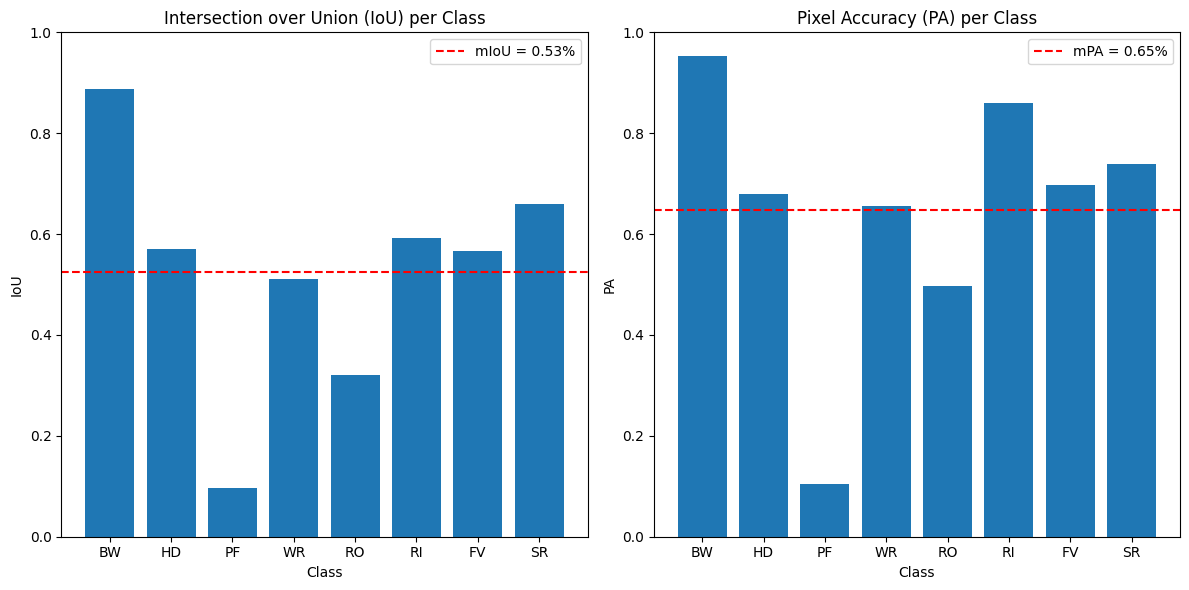


Final Test Results with Best Weights:
Test Loss: 0.5706
Accuracy: 0.8113
Mean IoU (mIoU): 0.5258
Mean Pixel Accuracy (mPA): 0.6479
Used Weights: CE=0.20, Dice=0.80


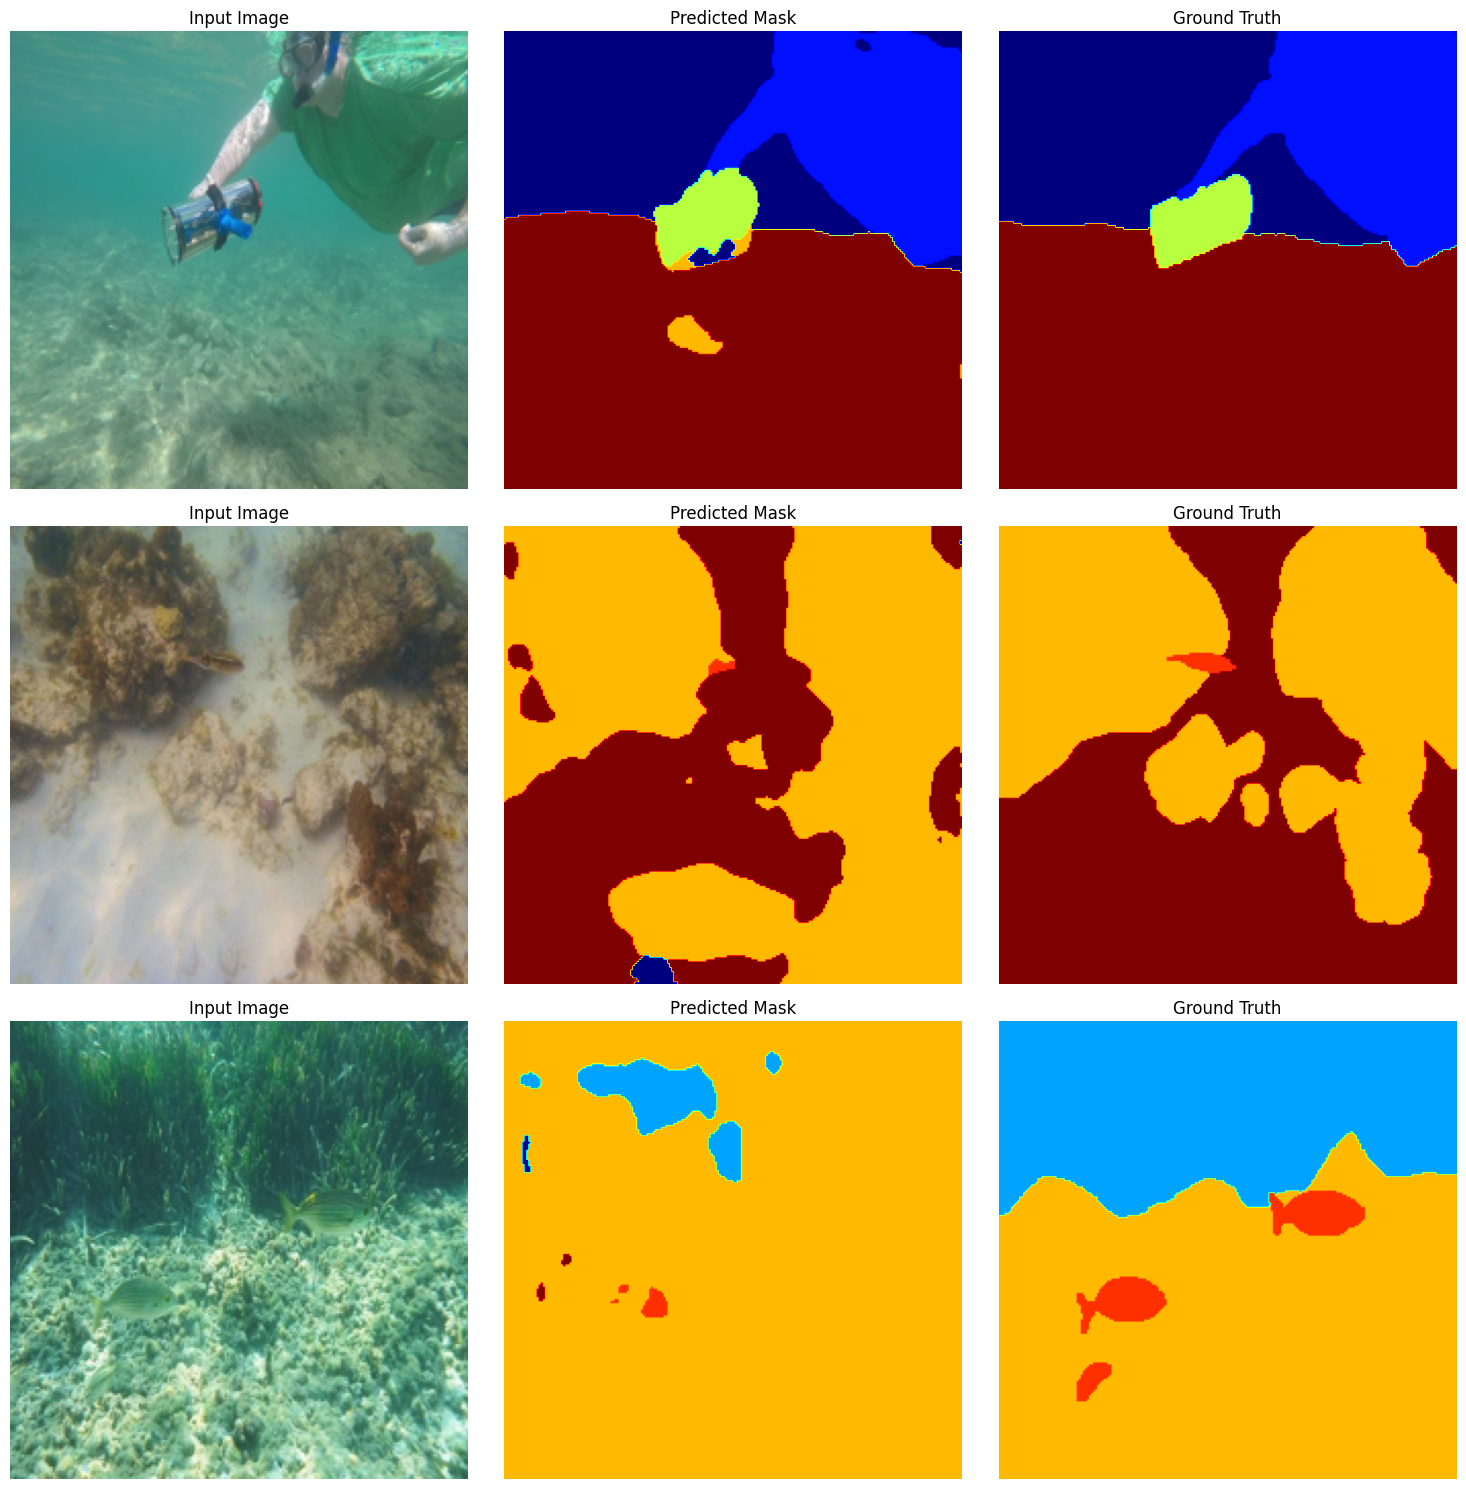

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.UpsamplingBilinear2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

Model Complexity Analysis:
Total FLOPs: 32.779G
Total Parameters: 75.417M


In [9]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchmetrics import JaccardIndex
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import math

 
def CE_Loss(inputs, target, cls_weights, num_classes=21):
    n, c, h, w = inputs.size()
    nt, ht, wt = target.size()
    if h != ht and w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)

    temp_inputs = inputs.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    temp_target = target.view(-1)

    CE_loss = nn.CrossEntropyLoss(weight=cls_weights, ignore_index=num_classes)(temp_inputs, temp_target)
    return CE_loss

def DiceLoss(inputs, target, beta=1, smooth=1e-5):
    n, c, h, w = inputs.size()   
    nt, ht, wt = target.size()  
    
    if h != ht or w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)
    
     
    temp_inputs = torch.softmax(inputs, dim=1)   
    temp_inputs = temp_inputs.permute(0, 2, 3, 1).contiguous().view(-1, c)   
    
   
    temp_target = torch.zeros(n * ht * wt, c, device=target.device)  
    temp_target.scatter_(1, target.view(-1, 1), 1)  
    
    # Compute Dice score
    tp = torch.sum(temp_target * temp_inputs, dim=0)  
    fp = torch.sum(temp_inputs, dim=0) - tp   
    fn = torch.sum(temp_target, dim=0) - tp  
    
    score = ((1 + beta ** 2) * tp + smooth) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    dice_loss = 1 - torch.mean(score)
    return dice_loss

def weights_init(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and classname.find('Conv') != -1:
            if init_type == 'normal':
                torch.nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                torch.nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                torch.nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)
    print('initialize network with %s type' % init_type)
    net.apply(init_func)

def get_lr_scheduler(lr_decay_type, lr, min_lr, total_iters, warmup_iters_ratio=0.05, warmup_lr_ratio=0.1, no_aug_iter_ratio=0.05, step_num=10):
    def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
        if iters <= warmup_total_iters:
            lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
        elif iters >= total_iters - no_aug_iter:
            lr = min_lr
        else:
            lr = min_lr + 0.5 * (lr - min_lr) * (
                1.0 + math.cos(math.pi * (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter))
            )
        return lr

    def step_lr(lr, decay_rate, step_size, iters):
        if step_size < 1:
            raise ValueError("step_size must above 1.")
        n = iters // step_size
        out_lr = lr * decay_rate ** n
        return out_lr

    if lr_decay_type == "cos":
        warmup_total_iters = min(max(warmup_iters_ratio * total_iters, 1), 3)
        warmup_lr_start = max(warmup_lr_ratio * lr, 1e-6)
        no_aug_iter = min(max(no_aug_iter_ratio * total_iters, 1), 15)
        func = partial(yolox_warm_cos_lr, lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
    else:
        decay_rate = (min_lr / lr) ** (1 / (step_num - 1))
        step_size = total_iters / step_num
        func = partial(step_lr, lr, decay_rate, step_size)

    return func

def set_optimizer_lr(optimizer, lr_scheduler_func, epoch):
    lr = lr_scheduler_func(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, resize_size=(224, 224)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.resize_size = resize_size
        self.resize_transform = transforms.Resize(resize_size, interpolation=Image.NEAREST)
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must be the same."
        self.class_map = {
            (0, 0, 0): 0,      # BW
            (0, 0, 255): 1,    # HD
            (0, 255, 0): 2,    # PF
            (0, 255, 255): 3,  # WR
            (255, 0, 0): 4,    # RO
            (255, 0, 255): 5,  # RI
            (255, 255, 0): 6,  # FV
            (255, 255, 255): 7 # SR
        }

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('RGB')
        
        image = self.resize_transform(image)
        mask = self.resize_transform(mask)
        
        image = np.array(image)
        mask = np.array(mask)
        
        mask_indices = np.zeros((self.resize_size[0], self.resize_size[1]), dtype=np.uint8)
        for rgb, idx in self.class_map.items():
            mask_indices[np.all(mask == rgb, axis=-1)] = idx
        
        if self.image_transform:
            augmented = self.image_transform(image=image, mask=mask_indices)
            image = augmented['image']
            mask_indices = augmented['mask']
            mask = mask_indices.long() if isinstance(mask_indices, torch.Tensor) else torch.from_numpy(mask_indices).long()
        else:
            mask = torch.from_numpy(mask_indices).long()
        
        return image, mask, img_name
 
class UnderwaterTestDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, target_size=(224, 224)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.target_size = target_size
        self.image_filenames = sorted(f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)))
        self.mask_filenames = sorted(f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f)))
        self.class_map = {
            (0, 0, 0): 0,      # BW
            (0, 0, 255): 1,    # HD
            (0, 255, 0): 2,    # PF
            (0, 255, 255): 3,  # WR
            (255, 0, 0): 4,    # RO
            (255, 255, 0): 6,  # FV
            (255, 0, 255): 5,  # RI
            (255, 255, 255): 7 # SR
        }

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_path).convert("RGB").resize(self.target_size)
        mask = Image.open(mask_path).convert("RGB").resize(self.target_size, resample=Image.NEAREST)
        
        mask = np.array(mask)
        mask_indices = np.zeros(self.target_size, dtype=np.uint8)
        for rgb, idx in self.class_map.items():
            mask_indices[np.all(mask == rgb, axis=-1)] = idx
        mask = torch.from_numpy(mask_indices).long()
        
        if self.image_transform:
            image = self.image_transform(image)
            
        return image, mask

 
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(p=0.3),
    A.ElasticTransform(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

 
batch_size = 6
image_paths = '/kaggle/input/underwater-image/train_val/train_val/images'
mask_paths = '/kaggle/input/underwater-image/train_val/train_val/masks'
train_dataset = CustomDataset(
    image_dir=image_paths,
    mask_dir=mask_paths,
    image_transform=train_transform
)

test_image_dir = "/kaggle/input/underwater-image/TEST/TEST/images"
test_mask_dir = "/kaggle/input/underwater-image/TEST/TEST/masks"
test_dataset = UnderwaterTestDataset(test_image_dir, test_mask_dir, image_transform=val_transform)

 
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UISS_Net(num_classes=8, backbone='resnet50', pretrained=True).to(device)

 
weights_init(model, init_type='kaiming')

 
num_epochs = 100
best_val_loss = float('inf')
best_weights = None
best_metrics = None
best_epoch = -1

 
weight_combinations = [
    [0.8, 0.2],
    [0.7, 0.3],
    [0.6, 0.4],
    [0.5, 0.5],
    [0.4, 0.6],
    [0.3, 0.7],
    [0.2, 0.8]
]

 
cls_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device)
optimizer = Adam(model.parameters(), lr=0.0004, betas=(0.5, 0.999), weight_decay=1e-4)
lr_scheduler_func = get_lr_scheduler(
    lr_decay_type="cos",
    lr=0.0004,
    min_lr=1e-5,
    total_iters=num_epochs
)

 
train_losses = []
val_losses = []
val_accuracies = []
mious = []
weight_history = []

for epoch in tqdm(range(num_epochs)):
 
    set_optimizer_lr(optimizer, lr_scheduler_func, epoch)
    
  
    model.train()
    epoch_train_loss = 0.0
    
    for images, masks, _ in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
     
        best_batch_loss = float('inf')
        best_batch_outputs = None
        
 
        for ce_weight, dice_weight in weight_combinations:
            ce_loss = CE_Loss(outputs, masks, cls_weights, num_classes=8)
            dice_loss = DiceLoss(outputs, masks)
            loss = ce_weight * ce_loss + dice_weight * dice_loss
            
            if loss.item() < best_batch_loss:
                best_batch_loss = loss.item()
                best_batch_outputs = outputs
                
 
        ce_loss = CE_Loss(best_batch_outputs, masks, cls_weights, num_classes=8)
        dice_loss = DiceLoss(best_batch_outputs, masks)
        loss = ce_weight * ce_loss + dice_weight * dice_loss   
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    
  
    model.eval()
    epoch_val_metrics = []
    
    with torch.no_grad():
        for ce_weight, dice_weight in weight_combinations:
            val_loss = 0.0
            all_preds = []
            all_labels = []
            
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                
          
                ce_loss = CE_Loss(outputs, masks, cls_weights, num_classes=8)
                dice_loss = DiceLoss(outputs, masks)
                loss = ce_weight * ce_loss + dice_weight * dice_loss
                val_loss += loss.item()
                
         
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(masks.view(-1).cpu().numpy())
            
            avg_val_loss = val_loss / len(test_loader)
            
  
            all_preds = np.array(all_preds)
            all_labels = np.array(all_labels)
            accuracy = accuracy_score(all_labels, all_preds)
            jaccard = JaccardIndex(task="multiclass", num_classes=8).to(device)
            miou = jaccard(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
            
    
            epoch_val_metrics.append({
                'ce_weight': ce_weight,
                'dice_weight': dice_weight,
                'val_loss': avg_val_loss,
                'accuracy': accuracy,
                'miou': miou.item()
            })
    
 
    best_weight_metrics = min(epoch_val_metrics, key=lambda x: x['val_loss'])
    avg_val_loss = best_weight_metrics['val_loss']
    accuracy = best_weight_metrics['accuracy']
    miou = best_weight_metrics['miou']
    ce_weight = best_weight_metrics['ce_weight']
    dice_weight = best_weight_metrics['dice_weight']
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Accuracy: {accuracy:.4f} | mIoU: {miou:.4f}")
    print(f"Best Weights: CE={ce_weight:.2f}, Dice={dice_weight:.2f}")
    
 
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    mious.append(miou)
    weight_history.append({'epoch': epoch+1, 'ce_weight': ce_weight, 'dice_weight': dice_weight})
    
 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_weights = {'ce_weight': ce_weight, 'dice_weight': dice_weight}
        best_metrics = {
            'val_loss': avg_val_loss,
            'accuracy': accuracy,
            'miou': miou
        }
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved new best model with CE={ce_weight:.2f}, Dice={dice_weight:.2f}")

 
print("\nBest Model Results:")
print(f"Epoch: {best_epoch}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"mIoU: {best_metrics['miou']:.4f}")
print(f"Best Weights: CE={best_weights['ce_weight']:.2f}, Dice={best_weights['dice_weight']:.2f}")

 
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []
test_loss = 0.0
ce_weight = best_weights['ce_weight']
dice_weight = best_weights['dice_weight']

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
 
        ce_loss = CE_Loss(outputs, masks, cls_weights, num_classes=8)
        dice_loss = DiceLoss(outputs, masks)
        loss = ce_weight * ce_loss + dice_weight * dice_loss
        test_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(masks.view(-1).cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

 
accuracy = accuracy_score(all_labels, all_preds)
jaccard = JaccardIndex(task="multiclass", num_classes=8).to(device)
miou = jaccard(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))

hist = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        hist[i, j] = np.sum((all_labels == i) & (all_preds == j))
pa_per_class = np.diag(hist) / (hist.sum(axis=1) + 1e-10)
mpa = np.mean(pa_per_class)

iou_per_class = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist) + 1e-10)

# Create bar plots for mIoU and mPA per class
class_names = ['BW', 'HD', 'PF', 'WR', 'RO', 'RI', 'FV', 'SR']

plt.figure(figsize=(12, 6))

# Plot per-class IoU
plt.subplot(1, 2, 1)
plt.bar(class_names, iou_per_class)
plt.axhline(y=miou.item(), color='r', linestyle='--', label=f'mIoU = {miou.item():.2f}%')
plt.title('Intersection over Union (IoU) per Class')
plt.xlabel('Class')
plt.ylabel('IoU')
plt.ylim(0, 1)
plt.legend()

# Plot per-class Pixel Accuracy
plt.subplot(1, 2, 2)
plt.bar(class_names, pa_per_class)
plt.axhline(y=mpa, color='r', linestyle='--', label=f'mPA = {mpa:.2f}%')
plt.title('Pixel Accuracy (PA) per Class')
plt.xlabel('Class')
plt.ylabel('PA')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

print("\nFinal Test Results with Best Weights:")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Mean IoU (mIoU): {miou.item():.4f}")
print(f"Mean Pixel Accuracy (mPA): {mpa:.4f}")
print(f"Used Weights: CE={ce_weight:.2f}, Dice={dice_weight:.2f}")

 
def visualize_results(loader, model, device, num_samples=3):
    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad():
        outputs = model(images[:num_samples])
        _, preds = torch.max(outputs, 1)
    
    images = images[:num_samples].cpu().permute(0, 2, 3, 1).numpy()
    masks = masks[:num_samples].cpu().numpy()
    preds = preds.cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = images * std + mean
    images = np.clip(images, 0, 1)
    
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.axis("off")
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(preds[i], cmap='jet', vmin=0, vmax=7)
        plt.title("Predicted Mask")
        plt.axis("off")
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(masks[i], cmap='jet', vmin=0, vmax=7)
        plt.title("Ground Truth")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

 
visualize_results(test_loader, model, device, num_samples=3)

 
from thop import profile, clever_format
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(model, inputs=(dummy_input,))
flops, params = clever_format([flops, params], "%.3f")
print("\nModel Complexity Analysis:")
print(f"Total FLOPs: {flops}")
print(f"Total Parameters: {params}")

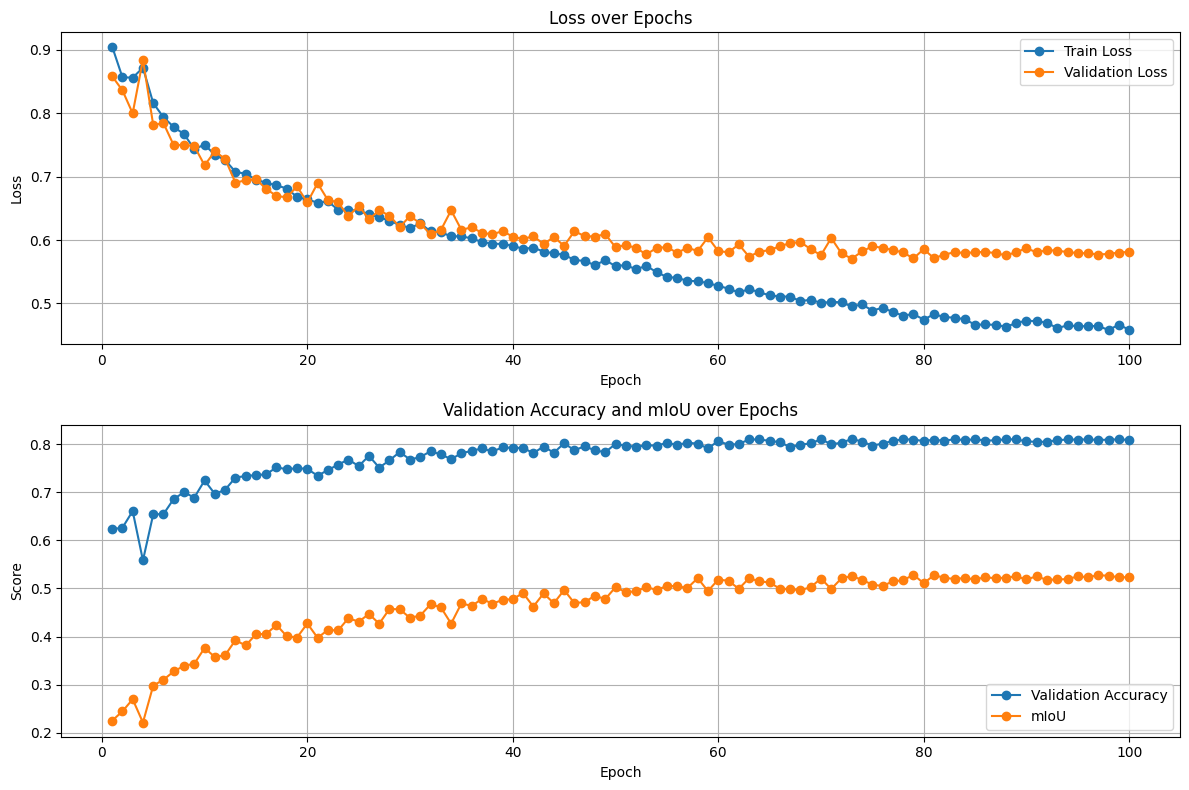

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot Losses
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy & mIoU
plt.subplot(2, 1, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(epochs, mious, label='mIoU', marker='o')
plt.title('Validation Accuracy and mIoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()